In [73]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json
import os

In [74]:
hex_scheduled = _hex_json.loads("false")

In [75]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [76]:
hex_user_attributes = _hex_json.loads("{}")

In [77]:
hex_run_context = _hex_json.loads("\"logic\"")

In [78]:
hex_timezone = _hex_json.loads("\"America/Los_Angeles\"")

In [79]:
hex_project_id = _hex_json.loads("\"bda382fa-e8af-4fae-b3bc-83610fcb4101\"")

In [80]:
hex_project_name = _hex_json.loads("\"2.1 Electricity Demand and Generation - Jenn\"")

In [81]:
hex_status = _hex_json.loads("\"Ready for review\"")

In [82]:
hex_categories = _hex_json.loads("[\"Lab 2.1: Utility data\"]")

In [83]:
hex_color_palette = _hex_json.loads("[\"#4C78A8\",\"#F58518\",\"#E45756\",\"#72B7B2\",\"#54A24B\",\"#EECA3B\",\"#B279A2\",\"#FF9DA6\",\"#9D755D\",\"#BAB0AC\"]")

In [84]:
EIA_API_KEY = os.getenv("EIA_API_KEY")


In [85]:
# Welcome to your first deep dive lab assignment!

# In this lab, you will:
#  0. Get introduced to some terminology around utility-scale electricity demand and generation
#  1. Fetch utility-scale electricity generation and demand timeseries data from the EIA API (using python `requests` package)
#  2. Plot the data to get an understanding of how it varies over time (using Hex's built-in chart widget)
#  3. Do or find something interesting with that data. Exactly what is dependent on your coding level, see below

In [86]:
# We'll reference these terms later in the notebook, so it's important to understand them now:

# Balancing authority (BA): the organization in charge of ensuring electricity generation meets electricity demand in a given region
#   A BA performs it's own local electricity generation, and then either net imports or net exports energy to other
#   connected BAs, depending on whether local electricity demand is larger or smaller than local electricity generation

# Grid mix: electricity generation breakdown by fuel type (e.g., coal, natural gas, solar, hydro, etc.)

In [87]:
# You will run the existing notebook, but you'll update it to access data from a different balancing authority (your own local BA if US-based)

# In the next cells, we are going to:
#  1. Import 3rd party libraries
#  2. Define some data access helper functions
#  3. Set some input variables (this is where you'll make some changes!)
#  4. Fetch data
#  5. Plot and explore the data

In [88]:
# In this cell, we're importing packages that we'll use later in the notebook
# You do not need to make changes to this cell

# 1st party packages (python standard library)
import datetime
import json
import requests

# 3rd party packages
from IPython import display
import pandas as pd

In [89]:
# In this cell, we've pre-defined some helper functions you will use to fetch data from the EIA API
# You do not need to make changes to this cell

# There are three types of data we're fetching:
#  1. Generation by fuel type (Megawatt-hours): how much electricity is being generated by each fuel type
#  2. Demand (Megawatt-hours): how much electricity is being consumed
#  3. Interchange: how much electricity is being imported/exported from other balancing authorities

default_end_date = datetime.date.today().isoformat()
default_start_date = (datetime.date.today() - datetime.timedelta(days=365)).isoformat()


def get_eia_timeseries(
    url_segment,
    facets,
    value_column_name="value",
    start_date=default_start_date,
    end_date=default_end_date,
):
    """
    A generalized helper function to fetch data from the EIA API
    """

    api_url = f"https://api.eia.gov/v2/electricity/rto/{url_segment}/data/?api_key={EIA_API_KEY}"

    response_content = requests.get(
        api_url,
        headers={
            "X-Params": json.dumps(
                {
                    "frequency": "daily",
                    "data": ["value"],
                    "facets": dict(**{"timezone": ["Pacific"]}, **facets),
                    "start": start_date,
                    "end": end_date,
                    "sort": [{"column": "period", "direction": "desc"}],
                    "offset": 0,
                    "length": 5000,  # This is the maximum allowed
                }
            )
        },
    ).json()

    # Sometimes EIA API responses are nested under a "response" key. Sometimes not 🤷
    if "response" in response_content:
        response_content = response_content["response"]

    # Handle warnings by displaying them to the user
    if "warnings" in response_content:
        display.display(
            display.Markdown(f"Warning(s) returned from EIA API:"),
            response_content["warnings"],
        )
    print(f"{len(response_content['data'])} rows returned")

    # Convert the data to a Pandas DataFrame and clean it up for plotting
    dataframe = pd.DataFrame(response_content["data"])
    dataframe["timestamp"] = dataframe["period"].apply(
        pd.to_datetime, format="%Y/%m/%dT%H"
    )
    dataframe.rename(columns={"value": value_column_name}, inplace=True)
    return dataframe


def get_eia_grid_mix_timeseries(balancing_authorities, **kwargs):
    """
    Fetch electricity generation data by fuel type
    """
    return get_eia_timeseries(
        url_segment="daily-fuel-type-data",
        facets={"respondent": balancing_authorities},
        value_column_name="Generation (MWh)",
        **kwargs,
    )


def get_eia_net_demand_and_generation_timeseries(balancing_authorities, **kwargs):
    """
    Fetch electricity demand data
    """
    return get_eia_timeseries(
        url_segment="daily-region-data",
        facets={
            "respondent": balancing_authorities,
            "type": ["D", "NG", "TI"],  # Filter out the "Demand forecast" (DF) type
        },
        value_column_name="Demand (MWh)",
        **kwargs,
    )


def get_eia_interchange_timeseries(balancing_authorities, **kwargs):
    """
    Fetch electricity interchange data (imports & exports from other utilities)
    """
    return get_eia_timeseries(
        url_segment="daily-interchange-data",
        facets={"toba": balancing_authorities},
        value_column_name=f"Interchange to local BA (MWh)",
        **kwargs,
    )

In [90]:
# In this cell, you'll be making one change!

# This cell defines the local balancing authority for which we're fetching grid mix data

# Currently, we've set this to "PSEI", i.e.Puget Sound Energy, Inc., the balancing authority for the region around Seattle, WA

# Change this to a different valid balancing authority:
#  - Visit the EIA API docs here: https://www.eia.gov/electricity/gridmonitor/dashboard/electric_overview/US48/US48
#  - Explore the map to find the 3-4 letter acronym representing a different balancing authority
#  - Update the line below with the value you found, then re-run this cell (Shift+Enter, or use the "play" icon in the upper right of this cell)
LOCAL_BALANCING_AUTHORITY = "WACM"

In [91]:
# In this cell, we put it all together and actually make a request against the EIA API to fetch electricity generation data
# You do not need to make changes to this cell

local_generation_grid_mix = get_eia_grid_mix_timeseries(
    LOCAL_BALANCING_AUTHORITY,
    # Optional: uncomment the lines below to try looking at a different time range to get data from other seasons.
    start_date="2022-01-01",
    end_date="2023-01-01",
)

# Listing this variable alone on the last line causes hex to display it, so we get a preview of the data as a table
local_generation_grid_mix

KeyError: 'data'

In [ ]:
import altair
chart_local_generation_grid_mix = altair.Chart.from_json(r"""
{
    "width": "container",
    "height": "container",
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "layer": [
        {
            "description": "outer data layer",
            "resolve": {
                "scale": {
                    "color": "independent",
                    "y": "shared"
                }
            },
            "layer": [
                {
                    "description": "area series layer",
                    "transform": [],
                    "layer": [
                        {
                            "description": "background area mark layer",
                            "mark": {
                                "type": "area",
                                "point": false,
                                "line": true,
                                "strokeJoin": "round",
                                "clip": true,
                                "cursor": "crosshair"
                            },
                            "encoding": {
                                "color": {
                                    "field": "type-name",
                                    "scale": {
                                        "range": [
                                            "#4C78A8",
                                            "#F58518",
                                            "#E45756",
                                            "#72B7B2",
                                            "#54A24B",
                                            "#EECA3B",
                                            "#B279A2",
                                            "#FF9DA6",
                                            "#9D755D",
                                            "#BAB0AC"
                                        ]
                                    },
                                    "legend": {
                                        "symbolOpacity": 1
                                    },
                                    "title": "type-name"
                                },
                                "opacity": {
                                    "value": 0.2
                                }
                            }
                        },
                        {
                            "transform": [],
                            "description": "area mark layer",
                            "mark": {
                                "type": "area",
                                "point": false,
                                "line": true,
                                "clip": true
                            },
                            "encoding": {
                                "color": {
                                    "field": "type-name",
                                    "scale": {
                                        "range": [
                                            "#4C78A8",
                                            "#F58518",
                                            "#E45756",
                                            "#72B7B2",
                                            "#54A24B",
                                            "#EECA3B",
                                            "#B279A2",
                                            "#FF9DA6",
                                            "#9D755D",
                                            "#BAB0AC"
                                        ]
                                    },
                                    "legend": {
                                        "symbolOpacity": 1
                                    },
                                    "title": "type-name"
                                }
                            }
                        },
                        {
                            "description": "pivot tooltip point mark layer",
                            "mark": {
                                "type": "point",
                                "tooltip": true,
                                "clip": true
                            },
                            "encoding": {
                                "opacity": {
                                    "value": 0,
                                    "condition": {
                                        "param": "pivot_hover_4c080afe-51ab-4f35-bf94-96a4ec2b9e78",
                                        "value": 1,
                                        "empty": false
                                    }
                                },
                                "size": {
                                    "value": 80
                                },
                                "tooltip": [
                                    {
                                        "field": "timestamp",
                                        "type": "temporal",
                                        "timeUnit": "yearmonthdatehours",
                                        "title": "timestamp"
                                    },
                                    {
                                        "field": "Generation (MWh)",
                                        "type": "quantitative",
                                        "aggregate": "sum",
                                        "formatType": "NUMBER_FORMATTER",
                                        "format": {
                                            "format": "NUMBER",
                                            "columnType": "NUMBER",
                                            "numDecimalDigits": -1,
                                            "currency": "$",
                                            "nanFormat": ""
                                        },
                                        "title": "Sum of Generation (MWh)"
                                    },
                                    {
                                        "field": "type-name",
                                        "type": "ordinal",
                                        "title": "type-name"
                                    }
                                ],
                                "color": {
                                    "field": "type-name",
                                    "scale": {
                                        "range": [
                                            "#4C78A8",
                                            "#F58518",
                                            "#E45756",
                                            "#72B7B2",
                                            "#54A24B",
                                            "#EECA3B",
                                            "#B279A2",
                                            "#FF9DA6",
                                            "#9D755D",
                                            "#BAB0AC"
                                        ]
                                    },
                                    "legend": {
                                        "symbolOpacity": 1
                                    },
                                    "title": "type-name"
                                },
                                "y": {
                                    "field": "Generation (MWh)",
                                    "type": "quantitative",
                                    "aggregate": "sum",
                                    "title": "Sum of Generation (MWh)",
                                    "scale": {},
                                    "axis": {
                                        "grid": true,
                                        "ticks": true,
                                        "labels": true,
                                        "labelFlush": false,
                                        "format": {
                                            "format": "NUMBER",
                                            "columnType": "NUMBER",
                                            "numDecimalDigits": -1,
                                            "currency": "$",
                                            "nanFormat": ""
                                        },
                                        "formatType": "NUMBER_FORMATTER"
                                    },
                                    "stack": "zero"
                                }
                            },
                            "params": [
                                {
                                    "name": "pivot_hover_4c080afe-51ab-4f35-bf94-96a4ec2b9e78",
                                    "select": {
                                        "type": "point",
                                        "on": "mouseover",
                                        "clear": "mouseout",
                                        "nearest": true,
                                        "fields": [
                                            "yearmonthdatehours_timestamp",
                                            "type-name"
                                        ]
                                    }
                                }
                            ]
                        }
                    ],
                    "encoding": {
                        "x": {
                            "field": "timestamp",
                            "type": "temporal",
                            "title": "timestamp (year-month-date-hours)",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "tickCount": {
                                    "expr": "length(domain('x')) > 0 ? min(ceil(width / 40), ceil((domain('x')[1] - domain('x')[0]) / 3600000)) : ceil(width / 40)"
                                },
                                "labels": true,
                                "labelFlush": false
                            },
                            "timeUnit": "yearmonthdatehours"
                        },
                        "y": {
                            "field": "Generation (MWh)",
                            "type": "quantitative",
                            "aggregate": "sum",
                            "title": "Sum of Generation (MWh)",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false,
                                "format": {
                                    "format": "NUMBER",
                                    "columnType": "NUMBER",
                                    "numDecimalDigits": -1,
                                    "currency": "$",
                                    "nanFormat": ""
                                },
                                "formatType": "NUMBER_FORMATTER"
                            }
                        }
                    }
                }
            ],
            "transform": [
                {
                    "calculate": "toDate(datum[\"timestamp\"])",
                    "as": "timestamp"
                },
                {
                    "filter": "isValid(datum[\"timestamp\"])"
                }
            ]
        }
    ],
    "config": {
        "legend": {
            "orient": "right"
        },
        "font": "\"IBM Plex Sans\", system-ui, -apple-system, BlinkMacSystemFont, sans-serif",
        "view": {}
    },
    "datasets": {
        "layer00": [
            {
                "name": "dummy",
                "value": 0
            }
        ]
    },
    "usermeta": {
        "selectionConfigs": {},
        "columnNameMappings": {}
    }
}
""")
chart_local_generation_grid_mix.datasets.layer00 = local_generation_grid_mix.to_json(orient='records')
chart_local_generation_grid_mix.display(actions=False)

In [ ]:
# If you're at coding level 0 or 1: Congrats, you made it through the code!

# Now, go back and play around with the data to look for interesting findings. Ideas:
#  - What is the primary electricity generation fuel type for the local balancing authority you chose? (e.g. for PSEI, it's natural gas)
# It appears to be coal
#  - Is there more or less clean electricity generation than you expected?
# Way lessm I didn't know coal was so prominent
#  - Are there any major seasonal trends?
# Coal seems to go up in the summer

# In your Assignment submission on the Terra.do app:
#  1. Link to your copy of this notebook
#  2. Write up a few sentences summarizing your interesting finding (you can share this in slack as well!)

In [ ]:
# If you have strong programming experience, or just want to wade further into the topic, continue on and we'll take it a level deeper!

# First, we're going to expand this notebook to expore the relationship between local vs imported electricity generation.
# Then, we'll provide some prompts for how you could expand the notebook further

# The chart above shows the local electricity generation for your LOCAL_BALANCING_AUTHORITY.
# However, for many balancing authorities, much of the electricity needed to meet demand is actually imported from other balancing authorities
# For example, PSEI imports a large amount of hydroelectric energy from the Bonneville Power Administration (BPAT)

# In this next section, we are going to combine datasets of demand (local) and generation (local and imported) to get a true representation of
# the "grid mix" (breakdown by fuel type) of local energy consumed

In [ ]:
# First, more terminology (https://www.eia.gov/electricity/gridmonitor/about)

# Demand (D): energy consumed locally
# Net generation (NG): energy generated locally
# Total interchange (TI): net energy exported (positive means net outflow, negative means net inflow)

# The balancing authority is responsible for balancing this equation:
# Total interchange = Net generation - Demand
# i.e. if local generation is larger than local demand, the BA is exporting electricity (positive total interchange)
#      if local demand is larger than local generation, the BA is importing electricity (negative total interchange)

In [ ]:
# There are two paths to consider:

# 1. Local BA is a net exporter of energy
# In this case, all electricity consumed locally comes from electricity generated locally, so the grid mix simply matches the local generation
# This turns out to be a trivial sub-case of path #2

# 2. Local BA is a net importer of energy
# When the local BA is net importing energy, that energy might come from multiple other BAs, each of which has their own grid mix
# Therefore, the grid mix of consumed electricity is a combination of local generation grid mix and imported generation grid mix

# To get a true representation of the grid mix of local energy, we need to combine these pieces of data:
#  - Demand, Net generation, and Total interchange for our LOCAL_BALANCING_AUTHORITY
#  - Interchange (quantitiy of imported energy) with each connected balancing authority
#  - Grid mix of imported energy from each connected balancing authority

In [ ]:
# In the code below, we fetch the daily Demand (D), Net generation (NG), and Total interchange (TI) numbers for the LOCAL_BALANCING_AUTHORITY
# You should see three rows for each date, one row each for TI, D, and NG.
# You can spot check a given day to confirm that TI = NG - D
demand_df = get_eia_net_demand_and_generation_timeseries([LOCAL_BALANCING_AUTHORITY])
demand_df

KeyError: 'data'

In [ ]:
interchange_df = get_eia_interchange_timeseries([LOCAL_BALANCING_AUTHORITY])
interchange_df

2351 rows returned


,period,fromba,fromba-name,toba,toba-name,timezone,Interchange to local BA (MWh),value-units,timestamp
0,2023-10-31,AZPS,Arizona Public Service Company,WACM,Western Area Power Administration - Rocky Moun...,Pacific,-5039,megawatthours,2023-10-31
1,2023-10-31,WALC,Western Area Power Administration - Desert Sou...,WACM,Western Area Power Administration - Rocky Moun...,Pacific,-2301,megawatthours,2023-10-31
2,2023-10-31,PNM,Public Service Company of New Mexico,WACM,Western Area Power Administration - Rocky Moun...,Pacific,-630,megawatthours,2023-10-31
3,2023-10-30,PNM,Public Service Company of New Mexico,WACM,Western Area Power Administration - Rocky Moun...,Pacific,-1244,megawatthours,2023-10-30
4,2023-10-30,PACE,PacifiCorp East,WACM,Western Area Power Administration - Rocky Moun...,Pacific,-9828,megawatthours,2023-10-30
...,...,...,...,...,...,...,...,...,...
2346,2022-11-28,WALC,Western Area Power Administration - Desert Sou...,WACM,Western Area Power Administration - Rocky Moun...,Pacific,-2055,megawatthours,2022-11-28
2347,2022-11-28,PSCO,Public Service Company of Colorado,WACM,Western Area Power Administration - Rocky Moun...,Pacific,8186,megawatthours,2022-11-28
2348,2022-11-28,AZPS,Arizona Public Service Company,WACM,Western Area Power Administration - Rocky Moun...,Pacific,-4248,megawatthours,2022-11-28
2349,2022-11-28,PNM,Public Service Company of New Mexico,WACM,Western Area Power Administration - Rocky Moun...,Pacific,2692,megawatthours,2022-11-28


In [ ]:
# How much energy is both generated and consumed locally
def get_energy_generated_and_consumed_locally(df):
    demand_stats = df.groupby("type-name")["Demand (MWh)"].sum()
    # If local demand is smaller than net (local) generation, that means: amount generated and used locally == Demand (net export)
    # If local generation is smaller than local demand, that means: amount generated and used locally == Net generation (net import)
    # Therefore, the amount generated and used locally is the minimum of these two
    return min(demand_stats["Demand"], demand_stats["Net generation"])


energy_generated_and_used_locally = demand_df.groupby("timestamp").apply(
    get_energy_generated_and_consumed_locally
)

consumed_locally_column_name = "Power consumed locally (MWh)"

# How much energy is imported and then used locally, grouped by the source BA (i.e. the BA which generated the energy)
energy_imported_then_consumed_locally_by_source_ba = (
    interchange_df.groupby(["timestamp", "fromba"])[
        "Interchange to local BA (MWh)"
    ].sum()
    # We're only interested in data points where energy is coming *in* to the local BA, i.e. where net export is negative
    # Therefore, ignore positive net exports
    .apply(lambda interchange: max(interchange, 0))
)

# Combine these two together to get all energy used locally, grouped by the source BA (both local and connected)
energy_consumed_locally_by_source_ba = pd.concat(
    [
        energy_imported_then_consumed_locally_by_source_ba.rename(
            consumed_locally_column_name
        ).reset_index("fromba"),
        pd.DataFrame(
            {
                "fromba": LOCAL_BALANCING_AUTHORITY,
                consumed_locally_column_name: energy_generated_and_used_locally,
            }
        ),
    ]
).reset_index()

In [ ]:
import altair
chart_energy_consumed_locally_by_source_ba = altair.Chart.from_json(r"""
{
    "width": "container",
    "height": "container",
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "layer": [
        {
            "description": "outer data layer",
            "resolve": {
                "scale": {
                    "color": "independent",
                    "y": "shared"
                }
            },
            "layer": [
                {
                    "description": "area series layer",
                    "transform": [],
                    "layer": [
                        {
                            "description": "background area mark layer",
                            "mark": {
                                "type": "area",
                                "point": false,
                                "line": true,
                                "strokeJoin": "round",
                                "clip": true,
                                "cursor": "crosshair"
                            },
                            "encoding": {
                                "color": {
                                    "field": "fromba",
                                    "scale": {
                                        "range": [
                                            "#4C78A8",
                                            "#F58518",
                                            "#E45756",
                                            "#72B7B2",
                                            "#54A24B",
                                            "#EECA3B",
                                            "#B279A2",
                                            "#FF9DA6",
                                            "#9D755D",
                                            "#BAB0AC"
                                        ]
                                    },
                                    "legend": {
                                        "symbolOpacity": 1
                                    },
                                    "title": "fromba"
                                },
                                "opacity": {
                                    "value": 0.2
                                }
                            }
                        },
                        {
                            "transform": [],
                            "description": "area mark layer",
                            "mark": {
                                "type": "area",
                                "point": false,
                                "line": true,
                                "clip": true
                            },
                            "encoding": {
                                "color": {
                                    "field": "fromba",
                                    "scale": {
                                        "range": [
                                            "#4C78A8",
                                            "#F58518",
                                            "#E45756",
                                            "#72B7B2",
                                            "#54A24B",
                                            "#EECA3B",
                                            "#B279A2",
                                            "#FF9DA6",
                                            "#9D755D",
                                            "#BAB0AC"
                                        ]
                                    },
                                    "legend": {
                                        "symbolOpacity": 1
                                    },
                                    "title": "fromba"
                                }
                            }
                        },
                        {
                            "description": "pivot tooltip point mark layer",
                            "mark": {
                                "type": "point",
                                "tooltip": true,
                                "clip": true
                            },
                            "encoding": {
                                "opacity": {
                                    "value": 0,
                                    "condition": {
                                        "param": "pivot_hover_a2e011f8-d5de-4eb4-b586-7701a5f2f3b5",
                                        "value": 1,
                                        "empty": false
                                    }
                                },
                                "size": {
                                    "value": 80
                                },
                                "tooltip": [
                                    {
                                        "field": "timestamp",
                                        "type": "temporal",
                                        "timeUnit": "yearmonthdatehours",
                                        "title": "timestamp"
                                    },
                                    {
                                        "field": "Power consumed locally (MWh)",
                                        "type": "quantitative",
                                        "formatType": "NUMBER_FORMATTER",
                                        "format": {
                                            "format": "NUMBER",
                                            "columnType": "NUMBER",
                                            "numDecimalDigits": -1,
                                            "currency": "$",
                                            "nanFormat": ""
                                        },
                                        "title": "Power consumed locally (MWh)"
                                    },
                                    {
                                        "field": "fromba",
                                        "type": "ordinal",
                                        "title": "fromba"
                                    }
                                ],
                                "color": {
                                    "field": "fromba",
                                    "scale": {
                                        "range": [
                                            "#4C78A8",
                                            "#F58518",
                                            "#E45756",
                                            "#72B7B2",
                                            "#54A24B",
                                            "#EECA3B",
                                            "#B279A2",
                                            "#FF9DA6",
                                            "#9D755D",
                                            "#BAB0AC"
                                        ]
                                    },
                                    "legend": {
                                        "symbolOpacity": 1
                                    },
                                    "title": "fromba"
                                },
                                "y": {
                                    "field": "Power consumed locally (MWh)",
                                    "type": "quantitative",
                                    "title": "Power consumed locally (MWh)",
                                    "scale": {},
                                    "axis": {
                                        "grid": true,
                                        "ticks": true,
                                        "labels": true,
                                        "labelFlush": false,
                                        "format": {
                                            "format": "NUMBER",
                                            "columnType": "NUMBER",
                                            "numDecimalDigits": -1,
                                            "currency": "$",
                                            "nanFormat": ""
                                        },
                                        "formatType": "NUMBER_FORMATTER"
                                    },
                                    "stack": "zero"
                                }
                            },
                            "params": [
                                {
                                    "name": "pivot_hover_a2e011f8-d5de-4eb4-b586-7701a5f2f3b5",
                                    "select": {
                                        "type": "point",
                                        "on": "mouseover",
                                        "clear": "mouseout",
                                        "nearest": true,
                                        "fields": [
                                            "yearmonthdatehours_timestamp",
                                            "fromba"
                                        ]
                                    }
                                }
                            ]
                        }
                    ],
                    "encoding": {
                        "x": {
                            "field": "timestamp",
                            "type": "temporal",
                            "title": "timestamp (year-month-date-hours)",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "tickCount": {
                                    "expr": "length(domain('x')) > 0 ? min(ceil(width / 40), ceil((domain('x')[1] - domain('x')[0]) / 3600000)) : ceil(width / 40)"
                                },
                                "labels": true,
                                "labelFlush": false
                            },
                            "timeUnit": "yearmonthdatehours"
                        },
                        "y": {
                            "field": "Power consumed locally (MWh)",
                            "type": "quantitative",
                            "title": "Power consumed locally (MWh)",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false,
                                "format": {
                                    "format": "NUMBER",
                                    "columnType": "NUMBER",
                                    "numDecimalDigits": -1,
                                    "currency": "$",
                                    "nanFormat": ""
                                },
                                "formatType": "NUMBER_FORMATTER"
                            }
                        }
                    }
                }
            ],
            "transform": [
                {
                    "calculate": "toDate(datum[\"timestamp\"])",
                    "as": "timestamp"
                },
                {
                    "filter": "isValid(datum[\"timestamp\"])"
                }
            ]
        }
    ],
    "config": {
        "legend": {
            "orient": "right"
        },
        "font": "\"IBM Plex Sans\", system-ui, -apple-system, BlinkMacSystemFont, sans-serif",
        "view": {}
    },
    "datasets": {
        "layer00": [
            {
                "name": "dummy",
                "value": 0
            }
        ]
    },
    "usermeta": {
        "selectionConfigs": {},
        "columnNameMappings": {}
    }
}
""")
chart_energy_consumed_locally_by_source_ba.datasets.layer00 = energy_consumed_locally_by_source_ba.to_json(orient='records')
chart_energy_consumed_locally_by_source_ba.display(actions=False)

In [ ]:
# Now that we know how much (if any) energy is imported by our local BA, and from which source BAs,
# let's get a full breakdown of the grid mix (fuel types) for that imported energy

# First, get a list of all source BAs: our local BA plus the ones we're importing from
all_source_bas = energy_consumed_locally_by_source_ba["fromba"].unique().tolist()

# Then, fetch the fuel type breakdowns for each of those BAs
generation_types_by_ba = get_eia_grid_mix_timeseries(all_source_bas).rename(
    {"respondent": "fromba", "type-name": "generation_type"}, axis="columns"
)

Warning(s) returned from EIA API:

[{'warning': 'incomplete return',
  'description': 'The API can only return 5000 rows in JSON format.  Please consider constraining your request with facet, start, or end, or using offset to paginate results.'}]

5000 rows returned


In [ ]:
# Okay, we've fetched all the data we need, now it's time to combine it all together!

# What follows is some heavy-lifting with the Pandas library to massage the data into the shape we want
# Pandas docs: https://pandas.pydata.org/docs/
# Pandas cheat sheet: https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf

# The goal is to get a DataFrame of energy used at the local BA (in MWh), broken down by both
#  * the BA that the energy came from, and 
#  * the fuel type of that energy.
# So we'll end up with one row for each combination of source BA and fuel type.

# To get there, we need to combine the amount of imported energy from each source ba with grid mix for that source BA.
# The general formula is:
# Power consumed locally from a (BA, fuel type) combination = 
#    total power consumed locally from this source BA * (fuel type as a % of source BA's generation)
# fuel type as a % of source BA's generation = 
#    (total generation at source BA) / (total generation for this fuel type at this BA)


total_generation_by_source_ba = generation_types_by_ba.groupby(["timestamp", "fromba"])[
    "Generation (MWh)"
].sum()

generation_types_by_ba_with_totals = generation_types_by_ba.join(
    total_generation_by_source_ba,
    how="left",
    on=["timestamp", "fromba"],
    rsuffix=" Total",
)
generation_types_by_ba_with_totals["Generation (% of BA generation)"] = (
    generation_types_by_ba_with_totals["Generation (MWh)"]
    / generation_types_by_ba_with_totals["Generation (MWh) Total"]
)
generation_types_by_ba_with_totals_and_source_ba_breakdown = generation_types_by_ba_with_totals.merge(
    energy_consumed_locally_by_source_ba.rename(
        {"Power consumed locally (MWh)": "Power consumed locally from source BA (MWh)"},
        axis="columns",
    ),
    on=["timestamp", "fromba"],
)
full_df_reindexed = (
    generation_types_by_ba_with_totals_and_source_ba_breakdown.set_index(
        ["timestamp", "fromba", "generation_type"]
    )
)
usage_by_ba_and_generation_type = (
    (
        full_df_reindexed["Power consumed locally from source BA (MWh)"]
        * full_df_reindexed["Generation (% of BA generation)"]
    )
    .rename("Usage (MWh)")
    .reset_index()
)
usage_by_ba_and_generation_type

,timestamp,fromba,generation_type,Usage (MWh)
0,2023-11-01,WACM,Hydro,10983.096779
1,2023-11-01,WACM,Natural gas,5264.077351
2,2023-11-01,WACM,Coal,62608.863595
3,2023-11-01,WACM,Solar,1213.767793
4,2023-11-01,WACM,Wind,5869.194482
...,...,...,...,...
4906,2023-07-10,WACM,Hydro,22317.067709
4907,2023-07-10,WACM,Coal,58364.107650
4908,2023-07-10,WACM,Natural gas,6704.735358
4909,2023-07-10,WACM,Wind,6245.089283


In [ ]:
import altair
chart_usage_by_ba_and_generation_type = altair.Chart.from_json(r"""
{
    "width": "container",
    "height": "container",
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "layer": [
        {
            "description": "outer data layer",
            "resolve": {
                "scale": {
                    "color": "independent",
                    "y": "shared"
                }
            },
            "layer": [
                {
                    "description": "area series layer",
                    "transform": [
                        {
                            "calculate": "if(datum[\"generation_type\"] === \"Coal\", 0, if(datum[\"generation_type\"] === \"Hydro\", 1, if(datum[\"generation_type\"] === \"Natural gas\", 2, if(datum[\"generation_type\"] === \"Nuclear\", 3, if(datum[\"generation_type\"] === \"Other\", 4, if(datum[\"generation_type\"] === \"Petroleum\", 5, if(datum[\"generation_type\"] === \"Solar\", 6, if(datum[\"generation_type\"] === \"Wind\", 7, 8))))))))",
                            "as": "6ccabc0f-7c22-4e19-8bd5-be00aac92162-custom-stack-order"
                        }
                    ],
                    "layer": [
                        {
                            "description": "background area mark layer",
                            "mark": {
                                "type": "area",
                                "point": false,
                                "line": true,
                                "strokeJoin": "round",
                                "clip": true,
                                "cursor": "crosshair"
                            },
                            "encoding": {
                                "color": {
                                    "field": "generation_type",
                                    "scale": {
                                        "range": [
                                            "#4C78A8",
                                            "#F58518",
                                            "#E45756",
                                            "#72B7B2",
                                            "#54A24B",
                                            "#EECA3B",
                                            "#B279A2",
                                            "#FF9DA6",
                                            "#9D755D",
                                            "#BAB0AC"
                                        ]
                                    },
                                    "sort": [
                                        "Coal",
                                        "Hydro",
                                        "Natural gas",
                                        "Nuclear",
                                        "Other",
                                        "Petroleum",
                                        "Solar",
                                        "Wind"
                                    ],
                                    "legend": {
                                        "symbolOpacity": 1
                                    },
                                    "title": "generation_type"
                                },
                                "order": {
                                    "field": "6ccabc0f-7c22-4e19-8bd5-be00aac92162-custom-stack-order",
                                    "sort": "descending"
                                },
                                "opacity": {
                                    "value": 0.2
                                }
                            }
                        },
                        {
                            "transform": [],
                            "description": "area mark layer",
                            "mark": {
                                "type": "area",
                                "point": false,
                                "line": true,
                                "clip": true
                            },
                            "encoding": {
                                "color": {
                                    "field": "generation_type",
                                    "scale": {
                                        "range": [
                                            "#4C78A8",
                                            "#F58518",
                                            "#E45756",
                                            "#72B7B2",
                                            "#54A24B",
                                            "#EECA3B",
                                            "#B279A2",
                                            "#FF9DA6",
                                            "#9D755D",
                                            "#BAB0AC"
                                        ]
                                    },
                                    "sort": [
                                        "Coal",
                                        "Hydro",
                                        "Natural gas",
                                        "Nuclear",
                                        "Other",
                                        "Petroleum",
                                        "Solar",
                                        "Wind"
                                    ],
                                    "legend": {
                                        "symbolOpacity": 1
                                    },
                                    "title": "generation_type"
                                },
                                "order": {
                                    "field": "6ccabc0f-7c22-4e19-8bd5-be00aac92162-custom-stack-order",
                                    "sort": "descending"
                                }
                            }
                        },
                        {
                            "description": "pivot tooltip point mark layer",
                            "mark": {
                                "type": "point",
                                "tooltip": true,
                                "clip": true
                            },
                            "encoding": {
                                "opacity": {
                                    "value": 0,
                                    "condition": {
                                        "param": "pivot_hover_6ccabc0f-7c22-4e19-8bd5-be00aac92162",
                                        "value": 1,
                                        "empty": false
                                    }
                                },
                                "size": {
                                    "value": 80
                                },
                                "tooltip": [
                                    {
                                        "field": "timestamp",
                                        "type": "temporal",
                                        "title": "timestamp"
                                    },
                                    {
                                        "field": "Usage (MWh)",
                                        "type": "quantitative",
                                        "aggregate": "sum",
                                        "formatType": "NUMBER_FORMATTER",
                                        "format": {
                                            "format": "NUMBER",
                                            "columnType": "NUMBER",
                                            "numDecimalDigits": -1,
                                            "currency": "$",
                                            "nanFormat": ""
                                        },
                                        "title": "Sum of Usage (MWh)"
                                    },
                                    {
                                        "field": "generation_type",
                                        "type": "ordinal",
                                        "title": "generation_type"
                                    }
                                ],
                                "color": {
                                    "field": "generation_type",
                                    "scale": {
                                        "range": [
                                            "#4C78A8",
                                            "#F58518",
                                            "#E45756",
                                            "#72B7B2",
                                            "#54A24B",
                                            "#EECA3B",
                                            "#B279A2",
                                            "#FF9DA6",
                                            "#9D755D",
                                            "#BAB0AC"
                                        ]
                                    },
                                    "sort": [
                                        "Coal",
                                        "Hydro",
                                        "Natural gas",
                                        "Nuclear",
                                        "Other",
                                        "Petroleum",
                                        "Solar",
                                        "Wind"
                                    ],
                                    "legend": {
                                        "symbolOpacity": 1
                                    },
                                    "title": "generation_type"
                                },
                                "order": {
                                    "field": "6ccabc0f-7c22-4e19-8bd5-be00aac92162-custom-stack-order",
                                    "sort": "descending"
                                },
                                "y": {
                                    "field": "Usage (MWh)",
                                    "type": "quantitative",
                                    "aggregate": "sum",
                                    "title": "Sum of Usage (MWh)",
                                    "scale": {},
                                    "axis": {
                                        "grid": true,
                                        "ticks": true,
                                        "labels": true,
                                        "labelFlush": false,
                                        "format": {
                                            "format": "NUMBER",
                                            "columnType": "NUMBER",
                                            "numDecimalDigits": -1,
                                            "currency": "$",
                                            "nanFormat": ""
                                        },
                                        "formatType": "NUMBER_FORMATTER"
                                    },
                                    "stack": "zero"
                                }
                            },
                            "params": [
                                {
                                    "name": "pivot_hover_6ccabc0f-7c22-4e19-8bd5-be00aac92162",
                                    "select": {
                                        "type": "point",
                                        "on": "mouseover",
                                        "clear": "mouseout",
                                        "nearest": true,
                                        "fields": [
                                            "timestamp",
                                            "generation_type"
                                        ]
                                    }
                                }
                            ]
                        }
                    ],
                    "encoding": {
                        "x": {
                            "field": "timestamp",
                            "type": "temporal",
                            "title": "timestamp",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false
                            }
                        },
                        "y": {
                            "field": "Usage (MWh)",
                            "type": "quantitative",
                            "aggregate": "sum",
                            "title": "Sum of Usage (MWh)",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false,
                                "format": {
                                    "format": "NUMBER",
                                    "columnType": "NUMBER",
                                    "numDecimalDigits": -1,
                                    "currency": "$",
                                    "nanFormat": ""
                                },
                                "formatType": "NUMBER_FORMATTER"
                            }
                        }
                    }
                }
            ],
            "transform": [
                {
                    "calculate": "toDate(datum[\"timestamp\"])",
                    "as": "timestamp"
                },
                {
                    "filter": "isValid(datum[\"timestamp\"])"
                }
            ]
        }
    ],
    "config": {
        "legend": {
            "orient": "right"
        },
        "font": "\"IBM Plex Sans\", system-ui, -apple-system, BlinkMacSystemFont, sans-serif",
        "view": {}
    },
    "datasets": {
        "layer00": [
            {
                "name": "dummy",
                "value": 0
            }
        ]
    },
    "usermeta": {
        "selectionConfigs": {},
        "columnNameMappings": {}
    }
}
""")
chart_usage_by_ba_and_generation_type.datasets.layer00 = usage_by_ba_and_generation_type.to_json(orient='records')
chart_usage_by_ba_and_generation_type.display(actions=False)

In [ ]:
# Depending on your coding comfort level, just making it to the end of this notebook and following along the code might feel like enough!

# If so, play around with the data and look for interesting findings. Ideas:
#  - Is there a single other BA that is the primary exporter of energy to your BA, or is it a pretty even mix?
# No
#  - Does your BA (or any BA!) ever switch between net import vs net export of energy?
# Seems like this BA is mostly net export
#  - Does including the grid mix of imported energy change the primary fuel source in the grid mix of your local BA?
# No, it's still coal :(
#  - ...?

# If you're up for more of a challenge, take it one step further and modify or expand this notebook. Here are some ideas:
#  - Find a way to convert from fuel type to CO2e emissions, and make a timeseries chart of total CO2e emissions or CO2e/kWh
#  - Fetch and plot the data as an hourly time series. Is there a time of day that has a higher proportion of renewable energy generation?
#  - Fetch longer time period of data (warning: you might have to do some pagination!) and look for yearly or seasonal trends
#  - Find a non-US source of utility data and update the notebook to use that instead
#  - ... choose your own adventure!

# In your Assignment submission on the Terra.do app:
#  1. Link to your copy of this notebook
#  2. Write up a few sentences summarizing your interesting finding (you can share this in slack as well!)

### 1. Convert Fuel Type to CO2e Emissions and Create a Timeseries Chart

To add CO2e emissions calculations:

1. **Define Emission Factors**,: Create a mapping of fuel types to their respective CO2e emission factors. These factors are typically in units of CO2e per MWh.
2. **Calculate Emissions**,: Multiply the amount of energy generated or consumed by the emission factor for each fuel type.
3. **Timeseries Chart**,: Use a plotting library like ,`**matplotlib**`, or ,`**seaborn**`, to create a timeseries chart of total CO2e emissions or CO2e per kWh.



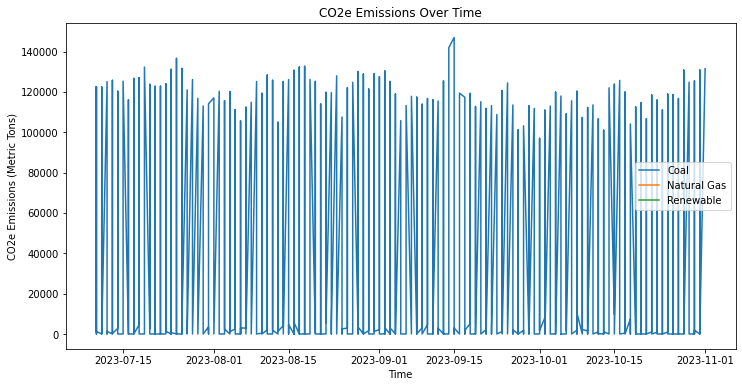

In [ ]:
# Example: Define emission factors (these are hypothetical values)
emission_factors = {'Coal': 2.1, 'Natural Gas': 1.2, 'Renewable': 0.1}
# add more

# Calculate CO2e emissions
usage_by_ba_and_generation_type['CO2e Emissions (Metric Tons)'] = (
    usage_by_ba_and_generation_type.apply(
        lambda row: row['Usage (MWh)'] * emission_factors.get(row['generation_type'], 0),
        axis=1
    )
)

# Plotting the timeseries chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for fuel_type in emission_factors.keys():
    subset = usage_by_ba_and_generation_type[usage_by_ba_and_generation_type['generation_type'] == fuel_type]
    plt.plot(subset['timestamp'], subset['CO2e Emissions (Metric Tons)'], label=fuel_type)

plt.xlabel('Time')
plt.ylabel('CO2e Emissions (Metric Tons)')
plt.title('CO2e Emissions Over Time')
plt.legend()
plt.show()


### 2. Fetch and Plot Hourly Time Series Data

To analyze hourly trends:

1. **Fetch Hourly Data**,: Ensure your data fetching function can retrieve data at an hourly granularity.
2. **Analyze Renewable Energy Proportion**,: Calculate the proportion of renewable energy generation for each hour.



<AxesSubplot:xlabel='timestamp'>

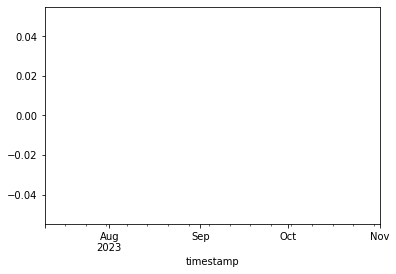

In [ ]:
# Assuming data is already in an hourly format
renewable_energy = usage_by_ba_and_generation_type[usage_by_ba_and_generation_type['generation_type'] == 'Renewable']
total_energy = usage_by_ba_and_generation_type.groupby('timestamp')['Usage (MWh)'].sum()

hourly_renewable_proportion = renewable_energy.groupby('timestamp')['Usage (MWh)'].sum() / total_energy
hourly_renewable_proportion.plot()  # Plotting the proportion


### 3. Fetch and Analyze Longer Time Period Data

For longer time period data:

1. **Pagination**,: If your data source requires pagination for large datasets, implement a loop in your data fetching function to handle this.
2. **Yearly/Seasonal Trends**,: Group data by year or season and analyze trends.



In [ ]:
def get_eia_timeseries_paginated(url_segment, facets, value_column_name="value", start_date=default_start_date, end_date=default_end_date, max_length=5000):
    """
    Modified function to handle pagination when fetching data from the EIA API.
    """

    all_data = []
    offset = 0
    total_fetched = 0

    while True:
        api_url = f"https://api.eia.gov/v2/electricity/rto/{url_segment}/data/?api_key={EIA_API_KEY}"
        response_content = requests.get(
            api_url,
            headers={
                "X-Params": json.dumps(
                    {
                        "frequency": "daily",
                        "data": ["value"],
                        "facets": dict(**{"timezone": ["Pacific"]}, **facets),
                        "start": start_date,
                        "end": end_date,
                        "sort": [{"column": "period", "direction": "desc"}],
                        "offset": offset,
                        "length": max_length,
                    }
                )
            },
        ).json()

        if "response" in response_content:
            response_content = response_content["response"]

        data = response_content.get("data", [])
        if not data or len(data) < max_length:
            break  # Break the loop if no more data to fetch

        all_data.extend(data)
        total_fetched += len(data)
        offset += max_length

        print(f"{total_fetched} rows fetched so far")

    dataframe = pd.DataFrame(all_data)
    dataframe["timestamp"] = dataframe["period"].apply(pd.to_datetime, format="%Y/%m/%dT%H")
    dataframe.rename(columns={"value": value_column_name}, inplace=True)
    return dataframe


In [ ]:
balancing_authorities = ["WACM"]
grid_mix_timeseries = get_eia_grid_mix_timeseries(balancing_authorities)


1695 rows returned


In [ ]:
import altair
chart_grid_mix_timeseries = altair.Chart.from_json(r"""
{
    "width": "container",
    "height": "container",
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "layer": [
        {
            "description": "outer data layer",
            "resolve": {
                "scale": {
                    "color": "independent",
                    "y": "shared"
                }
            },
            "layer": [
                {
                    "description": "bar series layer",
                    "transform": [],
                    "layer": [
                        {
                            "description": "bar mark layer",
                            "mark": {
                                "type": "bar",
                                "clip": true,
                                "filled": true,
                                "cursor": "pointer",
                                "orient": "vertical"
                            },
                            "encoding": {
                                "opacity": {
                                    "value": 1
                                },
                                "tooltip": [
                                    {
                                        "field": "period",
                                        "type": "ordinal",
                                        "title": "period"
                                    },
                                    {
                                        "field": "Generation (MWh)",
                                        "type": "quantitative",
                                        "aggregate": "sum",
                                        "formatType": "NUMBER_FORMATTER",
                                        "format": {
                                            "format": "NUMBER",
                                            "columnType": "NUMBER",
                                            "numDecimalDigits": -1,
                                            "currency": "$",
                                            "nanFormat": ""
                                        },
                                        "title": "Sum of Generation (MWh)"
                                    }
                                ],
                                "color": {
                                    "value": "#4C78A8"
                                },
                                "x": {
                                    "field": "period",
                                    "type": "ordinal",
                                    "title": "period",
                                    "scale": {},
                                    "axis": {
                                        "grid": true,
                                        "ticks": true,
                                        "labels": true,
                                        "labelFlush": false,
                                        "labelOverlap": "greedy"
                                    }
                                },
                                "y": {
                                    "field": "Generation (MWh)",
                                    "type": "quantitative",
                                    "aggregate": "sum",
                                    "title": "Sum of Generation (MWh)",
                                    "scale": {},
                                    "axis": {
                                        "grid": true,
                                        "ticks": true,
                                        "labels": true,
                                        "labelFlush": false,
                                        "format": {
                                            "format": "NUMBER",
                                            "columnType": "NUMBER",
                                            "numDecimalDigits": -1,
                                            "currency": "$",
                                            "nanFormat": ""
                                        },
                                        "formatType": "NUMBER_FORMATTER"
                                    }
                                }
                            }
                        }
                    ],
                    "encoding": {
                        "x": {
                            "field": "period",
                            "type": "ordinal",
                            "title": "period",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false,
                                "labelOverlap": "greedy"
                            }
                        },
                        "y": {
                            "field": "Generation (MWh)",
                            "type": "quantitative",
                            "aggregate": "sum",
                            "title": "Sum of Generation (MWh)",
                            "scale": {},
                            "axis": {
                                "grid": true,
                                "ticks": true,
                                "labels": true,
                                "labelFlush": false,
                                "format": {
                                    "format": "NUMBER",
                                    "columnType": "NUMBER",
                                    "numDecimalDigits": -1,
                                    "currency": "$",
                                    "nanFormat": ""
                                },
                                "formatType": "NUMBER_FORMATTER"
                            }
                        }
                    }
                }
            ],
            "transform": []
        }
    ],
    "config": {
        "legend": {
            "orient": "right"
        },
        "font": "\"IBM Plex Sans\", system-ui, -apple-system, BlinkMacSystemFont, sans-serif",
        "view": {}
    },
    "datasets": {
        "layer00": [
            {
                "name": "dummy",
                "value": 0
            }
        ]
    },
    "usermeta": {
        "selectionConfigs": {},
        "columnNameMappings": {}
    }
}
""")
chart_grid_mix_timeseries.datasets.layer00 = grid_mix_timeseries.to_json(orient='records')
chart_grid_mix_timeseries.display(actions=False)

### 4. Use a Non-US Source of Utility Data

1. **Data Source**,: Identify a non-US source of utility data that provides similar information.
2. **Adapt Fetching Function**,: Modify your data fetching function to retrieve and process data from this new source.



### 5. Choose Your Own Adventure!

- Explore additional analyses, like comparing the efficiency of different energy sources, or analyzing the impact of policy changes on energy usage patterns.
- Implement machine learning models to predict future energy consumption or generation patterns.

